# Molecular Maps: TSNE CLustering for POST Trimming

Author: AlvaroVM [https://alvarovm.github.io](http://alvarovm.github.io)
Version: 0.0.1

## Example 1: PCA to distinguish between rings and chains

For this example we define in SMILES string two groups of molecules with different substituents, such as -CH3, -O, -F, -Cl, and- I , in molecules with six carbons 1) in a ring and 2) in chain. Those molecules would be added to a list, additionally we add a 'certain' property , this could be used later as a flag.

In [1]:
import sys
import os
SRC_DIR='../..'

In [2]:
sys.path.append(os.path.join(SRC_DIR, 'code'))
import utils

/home/vama/soft/python-tests/solarcelldata/notebooks/answers/../../code/utils.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
#https://github.com/jmcarpenter2/swifter
#import swifter
#2-TSNE-UMAP-map-cuda-Copy1

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs 
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import  GetHashedMorganFingerprint
from rdkit.DataStructs import ConvertToNumpyArray

from sklearn.manifold import TSNE

import hdbscan

import seaborn as sns

utils.plot_settings2()

results_path = os.path.join(SRC_DIR,'results')

In [4]:
df = pd.read_pickle('../../data/extended_db_Zindo_Nov_2019_V5_cannfp.pkl').fillna(value = 0)
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))
#df.head(2)

Column names: ['smiles', 'inchikey', 'fpfail', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodpost', 'mol', 'morganfps-b', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'gapdft', 'gapz', 'gapmopac']
Table Shape: (7177, 49)


### Exercises
* Take a sample of 1000 rows from the data set

In [5]:
df = df.sample(n=1000, random_state=1)

* Select only the rows with `lambda_exp_max (nm)` between 200 and 800 nm

In [6]:
#tag='lambda_exp_max (nm)'
tag='lambda_sTDA (nm)'
df=df[df['lambda_sTDA (nm)']<600]
df=df[df['lambda_sTDA (nm)']>250]
print('Table Shape: {}'.format(df.shape))

Table Shape: (904, 49)


* Print a histogram plot (use Seaborn and `distplot`)

/tmp/ipykernel_20113/2414185178.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df['lambda_exp_max (nm)'])
/tmp/ipykernel_20113/2414185178.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df['lambda_exp_min (nm)'])


<function matplotlib.pyplot.show(close=None, block=None)>

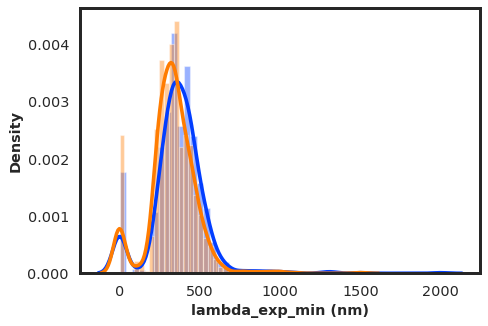

In [7]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.distplot( df['lambda_exp_max (nm)'])
sns.distplot( df['lambda_exp_min (nm)'])
plt.show

* Take the fingerprint column and `X=df['morganfps'].values.tolist()` and perfomen a t-SNE cluster analysis, as  `tsne = TSNE(n_components=2, metric='jaccard',perplexity=15, n_iter=3000, init='pca', random_state=23)`

In [8]:
X=df['morganfps-b'].values.tolist()
X = np.array(X, order='C')
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
#tsne = TSNE(n_components=2, metric=tanimoto_dist,perplexity=50)

tsne = TSNE(n_components=2, metric='jaccard',perplexity=50, init='pca',n_iter=1000)
#tsne = TSNE(n_components=2, metric='jaccard',perplexity=50, n_iter=250)
#tsne = TSNE(n_components=2, metric='jaccard',perplexity=50, n_iter=1000, init='pca', random_state=0)

tsne_X = tsne.fit_transform(X)

/home/vama/anaconda3/envs/introhpc/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


* Plot the t-SNE analysis in 2D graph colored by the `lambda_exp_max (nm)`

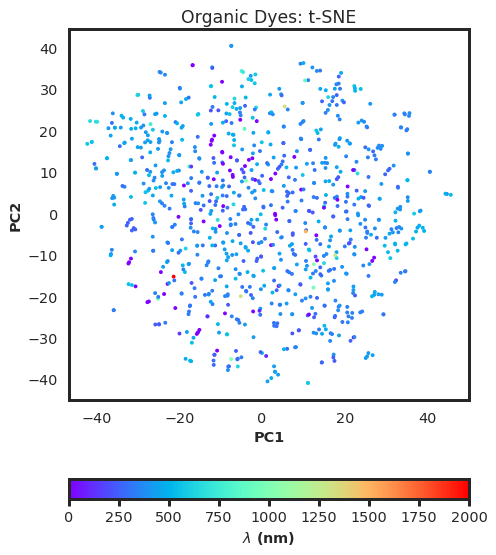

In [9]:
plt.figure(figsize=(6,8))
plt.scatter(tsne_X.T[0], tsne_X.T[1], marker='o',c=df[ 'lambda_exp_max (nm)'].values[:],s=5, cmap='rainbow')

#plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], 
#             color='blue', marker='o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Organic Dyes: t-SNE')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$\lambda$ (nm)')
#cbar.ax.set_ylabel('Cluster Id',rotation=270,labelpad=25)
#utils.save_figure(results_path,'tsne-dyes')
plt.show()

* Identify how many clusters are in the data using HDSCAN to the t-SNE output, try with `15` clusters as `cluster_tsne = hdbscan.HDBSCAN(min_cluster_size=15 , gen_min_span_tree=True)

In [10]:
cluster_tsne = hdbscan.HDBSCAN(min_cluster_size=15
                               , gen_min_span_tree=True)
cluster_tsne.fit(tsne_X)

df['cluster']=cluster_tsne.labels_
df['clusterprob']=cluster_tsne.probabilities_

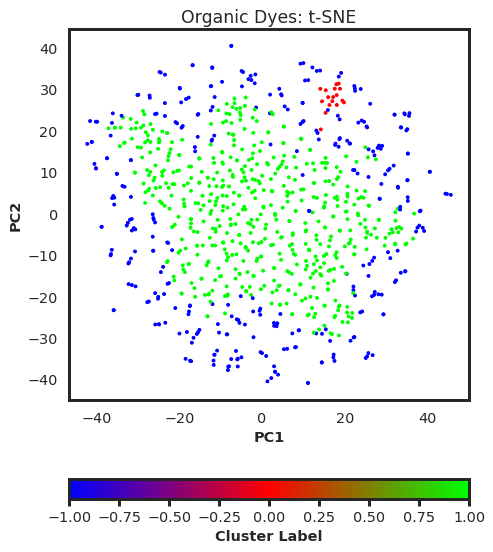

In [11]:
plt.figure(figsize=(6,8))
plt.scatter(tsne_X.T[0], tsne_X.T[1], marker='o',c=cluster_tsne.labels_,s=5, cmap='brg')
#plt.scatter(tsne_X.T[0], df[ 'lambda_sTDA (nm)'][x_index].values[:]  , marker='o',c=cluster_tsne.labels_,s=50, cmap='hsv')
        

#plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], 
#             color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Organic Dyes: t-SNE')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('Cluster Label')
plt.show()

* Add the cluster information and to the`Dataframework` and visualize the molecules, compare the molecules and determine if the molecules have something in common

In [12]:
df.to_pickle('../../data/extended_db_Zindo_Nov_2019_V5_cannfp_clust.pkl')

In [ ]:
#from cuml.manifold import TSNE as cutsne
#cumltsne = cutsne(n_components=2, metric='jaccard',perplexity=50, n_iter=2000, init='pca', random_state=0)
##cumltsne = cutsne(n_components=2,perplexity=50, n_iter=2000,  random_state=0)
#cumltsne_X = cumltsne.fit_transform(Xmat)

In [ ]:
# plt.figure(figsize=(6,8))
# tag='lambda_sTDA (nm)'
# plt.scatter(tsne_X.T[0], tsne_X.T[1], marker='o',c=df[tag].values[:],s=5, cmap='rainbow')

# #plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], 
# #             color='blue', marker='o', alpha=0.5)
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title('Organic Dyes: t-SNE')
# cbar = plt.colorbar(orientation='horizontal')
# cbar.set_label(r'b) sTDA $\lambda_{max}$ (nm)')
# #cbar.ax.set_ylabel('Cluster Id',rotation=270,labelpad=25)
# utils.save_figure(results_path,'tsne-dyes__lem_sta')
# plt.show()

### Cluster analysis

In [ ]:
cluster_tsne = hdbscan.HDBSCAN(min_cluster_size=15
                               , gen_min_span_tree=True)

In [ ]:
cluster_tsne.fit(tsne_X)

In [ ]:
df.to_pickle('../data/extended_db_Zindo_Nov_2019_V5_cannfp_clust_lem.pkl')

## Butina analysis of a cluster

In [ ]:
def ClusterFps(fps,cutoff=0.2):
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs